In [ ]:
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import numpy as np
import pandas as pd
import pickle
import ipywidgets
import seaborn as sns

In [2]:
def load_pickle(p):
    with open(p,"rb") as f:
        df=pickle.load(f)
    return df

In [3]:
start_distance=27000
end_distance=42000
L=end_distance-start_distance

In [ ]:
# load the observation data
track=load_pickle("../data/04_feature/sec27/track/10m/track_dataset.pkl")

dates=track["date"].unique()
track

In [ ]:
# load the data that ConvLSTM forecasted
run_id=10001
target,pred,_,calc_dates=load_pickle("../data/07_model_output/conv_lstm/regression/{}.pkl".format(run_id))

convlstm_df=pd.DataFrame(index=range((len(calc_dates))*(L)),columns=["date","distance","score"])
convlstm_df["date"]=np.repeat(calc_dates,L)
convlstm_df["date"]=pd.to_datetime(convlstm_df["date"])
convlstm_df["distance"]=np.repeat(np.arange(start_distance,end_distance).reshape(1,-1),len(calc_dates),axis=0).flatten()
convlstm_df["score"]=pred[:,0,:,].flatten()
convlstm_df

In [ ]:
# load the data that linear regression forecasted
linear_df=load_pickle("../data/07_model_output/Linear/regression/3/sec27.pkl".format(run_id))

linear_df=linear_df[["left_surface_LR_pred"]]
linear_df=linear_df.reset_index()
linear_df=linear_df.sort_values(["date","distance"])
linear_df=linear_df.rename(columns={"left_surface_LR_pred":"score"}).copy()
linear_df

In [ ]:
test_date="2018/11/07"
input_len=5
dates=track.loc[track["date"]>test_date,"date"].unique()
dates=dates[input_len:]
dates

In [ ]:
# calc RMSE of ConvLSTM for each point
convlstm_df=pd.merge(convlstm_df,track[["date","distance","left_surface"]],on=["date","distance"],how="left")
convlstm_df=convlstm_df.loc[convlstm_df["date"].isin(dates)]
convlstm_df["error"]=convlstm_df["score"]-convlstm_df["left_surface"]
convlstm_df["square_error"]=convlstm_df["error"]*convlstm_df["error"]
convlstm_mse_df=convlstm_df[["distance","square_error"]].groupby("distance").mean()
convlstm_mse_df["model"]="ConvLSTM"
convlstm_mse_df["square_error"]=convlstm_mse_df["square_error"].apply(np.sqrt)
convlstm_mse_df=convlstm_mse_df.reset_index()
convlstm_mse_df

In [ ]:
# calc RMSE of linear regression for each point
linear_df=pd.merge(linear_df,track[["date","distance","left_surface"]],on=["date","distance"],how="left")
linear_df=linear_df.loc[linear_df["date"].isin(dates)]
linear_df["error"]=linear_df["score"]-linear_df["left_surface"]
linear_df["square_error"]=linear_df["error"]*linear_df["error"]
linear_mse_df=linear_df[["distance","square_error"]].groupby("distance").mean()
linear_mse_df["model"]="Linear"
linear_mse_df["square_error"]=linear_mse_df["square_error"].apply(np.sqrt)
linear_mse_df=linear_mse_df.reset_index()
linear_mse_df

In [ ]:
# load the maintenance data
work_df=load_pickle("../data/04_feature/sec27/10m/work_unrolled.pkl")
work_df["work"]=work_df[["fix_uneven","tamping","marutai","exchange_ballast","exchange_rail_r","exchange_rail_l","disposal_mud","sleeper","others"]].sum(axis=1)
work_df=work_df[["date","distance","work"]]
work_df

In [ ]:
# count number of maintenance for each point
work=work_df[["distance","work"]].groupby("distance").sum().reset_index()
work

In [27]:
# calc number of maintenance per year
from datetime import timedelta
td=pd.to_datetime(dates[-1])-pd.to_datetime(dates[0])
work["work_per_year"]=work["work"]/(td/timedelta(days=365))

In [ ]:
# concat data
draw_df=pd.concat([linear_mse_df,convlstm_mse_df])
draw_df

In [ ]:
# merge data
draw_df=pd.merge(draw_df,work,on="distance")
draw_df

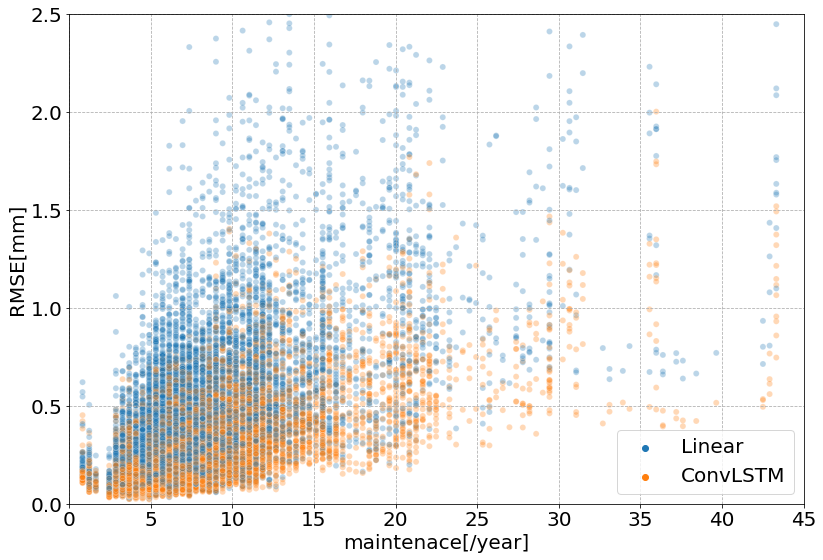

In [33]:
# visualize figure 6
fontsize=20
fig,ax = plt.subplots(figsize=(12,8))
sns.scatterplot(data=draw_df,x="work_per_year",y="square_error",hue="model",alpha=0.3,ax=ax)
ax.set_xlim(0,45)
ax.set_ylim(0,2.5)
ax.set_xlabel("maintenace[/year]",fontsize=fontsize)
ax.set_ylabel("RMSE[mm]",fontsize=fontsize)
ax.tick_params(labelsize=fontsize)
ax.grid(alpha=1,linestyle="dashed")
ax.legend(fontsize=fontsize)
ax.plot()
fig.subplots_adjust(left=0.1, right=0.95, bottom=0.1, top=0.95)
fig.savefig("./scatter1.pdf")

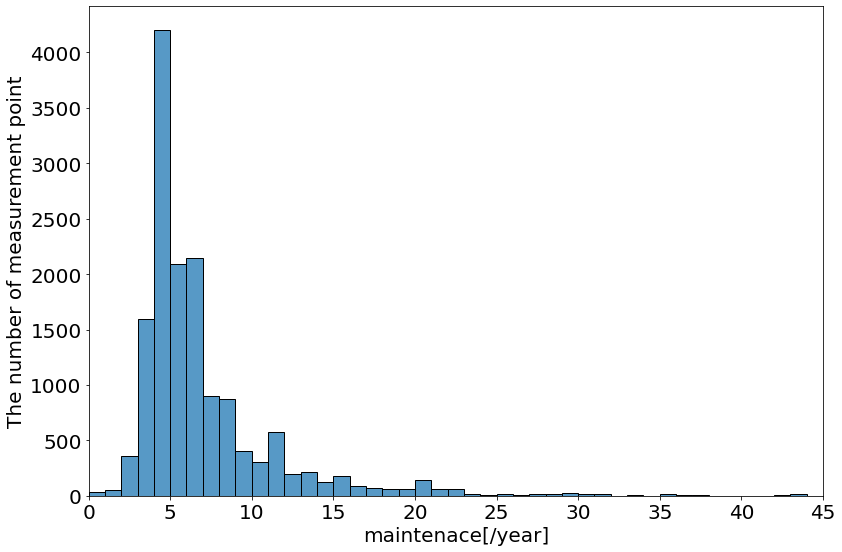

In [94]:
# visualize figure 5
fig,ax = plt.subplots(figsize=(12,8))
ax=sns.histplot(data=work,x="work_per_year",bins=np.arange(0,45+1e-6,1))
ax.set_xlim(0,45)
ax.set_xlabel("maintenace[/year]",fontsize=fontsize)
ax.set_ylabel("The number of measurement point",fontsize=fontsize)
ax.tick_params(labelsize=fontsize)
ax.plot()
fig.subplots_adjust(left=0.1, right=0.95, bottom=0.1, top=0.95)
fig.savefig("./hist.pdf")